# Comparing journey times returned by Mapzen's OSRM and [Valhalla](https://mapzen.com/projects/valhalla) instances, and the Google Maps Directions API

If you'd like to run this analysis locally, install the packages from `requirements.txt`

Commit 2a64889 has the old 'dirty' version of this notebook, including route retrieval functionality 

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import json
from itertools import chain
import requests
from shapely.geometry import (
    mapping, Point, Polygon,
    LineString, MultiLineString, MultiPolygon, box)

from geojson import (
    Feature, FeatureCollection,
    LineString as gj_ls,
    MultiLineString as gj_ml,
    dumps as gj_dumps)

from shapely.ops import unary_union
import fiona
from descartes import PolygonPatch

import statsmodels
import statsmodels.formula.api as sm

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

from helpers import decode_polyline, project_linestring
from IPython.core.display import HTML

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Skip the next cell if you don't want font customisation

In [2]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Adobe Garamamond Pro']})

Skip the next cell if you don't have LaTeX installed

In [3]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

The journey times and routes were retrieved by calling Mapzen's [OSRM](https://github.com/urschrei/Geopython/blob/6b504b857a736c3b011755ce44821cefdefd70bf/isochrone.ipynb) and [Valhalla](https://github.com/urschrei/Geopython/blob/master/isochrone.ipynb) instances, respectively, and by calling the Google Maps [Directions API](https://console.developers.google.com/project/london-bikeshare-routes/apiui/apiview/directions_backend/usage).  

`helpers.py` includes functions and examples for retrieving the above data into a Pandas DataFrame

Journeys were calculated from the *approximate* London Bike Share network centroid, on Westminster Bridge, to each station in the network.  
Calls to OSRM used `viaroute=bicycle`, calls to Valhalla used `{costing: bicycle}`  
No costing options were set for Valhalla or Google Maps.  

The journey times were retrieved from `['route_summary']['total_time']` for OSRM  
The journey times were retrieved from `['trip']['summary']['time']` for Valhalla  
The journey times were retrieved by summing the `duration` value for each step in each leg from `route[0]` for Google Maps.

In [4]:
routes = pd.read_csv("complete.csv", index_col=0)

####Journey origin is:

-0.12203999999842599, 51.500829999995766 (lon, lat)  
27054.81221603953, 25108.754540393566 (projected coordinates)  

`centroid_distance` is calculated using pythagoras' theorem  
`travel_time` is calculated in minutes (returned journey time / 60)

In [5]:
routes.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time_osrm,travel_time_valhalla,travel_time_gmaps,gmaps_route,valhalla_route,osrm_route
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,22.293144,17.133333,20.666667,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJuDD}FGiFi...
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.789598,17.333333,31.283333,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAFD~BpBNJGRWnB]...,isjfaBljmF}@~k@t@zOFvDGfUGzC?~DF|SOlJGtHE~Eu@t...,osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJGtHI`Fm@r...
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342662,27451.475186,4503.092527,23.073286,19.300000,22.183333,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,osjfaBnhmFnCo~BJqMNc_@oAsPBsHFcJFsGZ_m@N}JeBU}...
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,24.231678,16.233333,22.550000,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJuDD}FGiFi...
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,15.366430,10.950000,19.800000,ewiyHxyVt_@rDjJlAfBp@vFbE^\tAjCDHBNCHE@CH@D|Dv...,isjfaBljmF}@~k@t@zOFvDGfUGzC?~DF|SOlJGtHE~Eu@t...,osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJGtHI`Fm@r...


Cluster journeys using k-means++

In [6]:
centroids = {}
for provider in ['osrm', 'valhalla', 'gmaps']:

    km = KMeans(init='k-means++', n_clusters=7, n_init=10)
    km.fit(routes[['centroid_distance', 'travel_time_%s' % provider]])
    routes['kmeans_bin_%s' % provider] = km.labels_
    centroids[provider] = km.cluster_centers_

## Visualising Differences in Route Geography

As a next step, we're going to visualise the different routes returned by Valhalla and OSRM. In order to do this, we need to decode the polyline-encoded route strings, collect these, and map them.

We'll need the `Basemap` matplotlib extension in order to create these static maps.

In [7]:
for provider in ['osrm', 'valhalla', 'gmaps']:
    if provider == 'gmaps':
        routes['%s_decoded' % provider] = routes.apply(
            lambda f: decode_polyline(f['%s_route' % provider], gmaps=True), axis=1)
    else:
        routes['%s_decoded' % provider] = routes.apply(
            lambda f: decode_polyline(f['%s_route' % provider]), axis=1)

Now set up a map, and project our routes into map coordinates

In [8]:
bds = MultiLineString(list(routes['valhalla_decoded'])).bounds
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [9]:
m = Basemap(
    projection='tmerc',
    lon_0 = -0.12203999999842599,
    lat_0 = 51.500829999995766,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    resolution='i',
    suppress_ticks=True)

We can now create the projected versions of our routes, and combine each provider's routes into a MultiLineString

In [10]:
combined_routes = {}
for provider in ['osrm', 'valhalla', 'gmaps']:
    # create projected version of routes
    routes['%s_decoded_proj' % provider] = routes.apply(
        lambda f: project_linestring(f['%s_decoded' % provider], m), axis=1)
    # combine projected route LineStrings
    combined_routes[provider] = MultiLineString(list(routes['%s_decoded_proj' % provider]))
    # we can also calculate the projected route distances (as opposed to euclidean distance, as above)
    routes['%s_route_length_proj' % provider] = routes.apply(
        lambda f: f['%s_decoded_proj' % provider].length, axis=1)

Let's carry out some regressions in order to determine time/great-circle route distance correlation

In [37]:
# OSRM regression
regressions = []
for provider in ['osrm', 'valhalla', 'gmaps']:
    regressions.append(
        sm.ols(formula='%s_route_length_proj ~ travel_time_%s' % (provider, provider),
        data=routes).fit())

for res in regressions:
    print res.summary2()

                     Results: Ordinary least squares
Model:              OLS                    Adj. R-squared:     0.997    
Dependent Variable: osrm_route_length_proj AIC:                6887.2116
Date:               2015-08-10 14:10       BIC:                6895.8459
No. Observations:   554                    Log-Likelihood:     -3441.6  
Df Model:           1                      F-statistic:        2.006e+05
Df Residuals:       552                    Prob (F-statistic): 0.00     
R-squared:          0.997                  Scale:              14622.   
------------------------------------------------------------------------
                      Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------------
Intercept            484.9677  11.0771  43.7811 0.0000 463.2093 506.7262
travel_time_osrm     162.9790   0.3639 447.8805 0.0000 162.2642 163.6938
-----------------------------------------------------------------------

The OSRM journeys look almost perfectly correlated, whereas the Valhalla journeys don't.

**WHAT IS GOING ON WITH GOOGLE MAPS THOUGH**

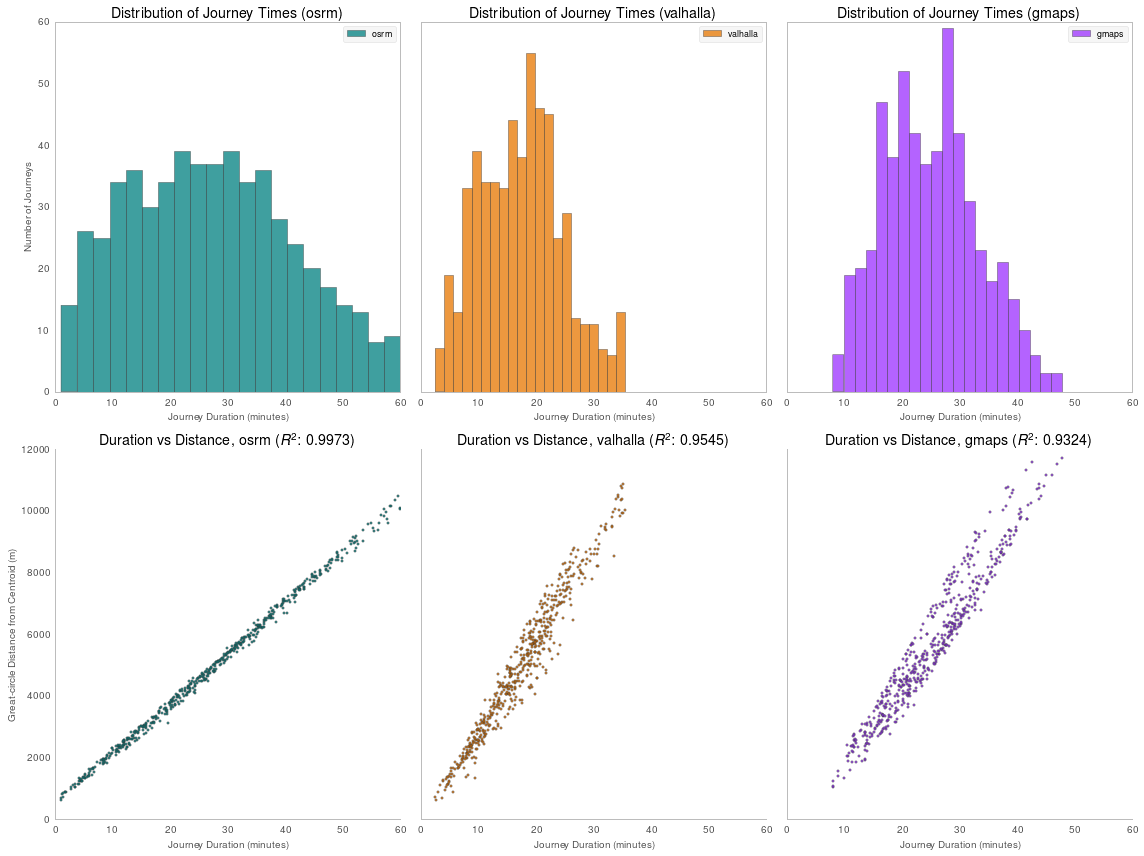

In [45]:
dotsize = 5.
linewidth = .5
fontsize = 10

plt.clf()
fig = plt.figure(figsize=(16, 12))

# define a grid of subplots
axes = [
    plt.subplot2grid((2, 3), (0, 0)),
    plt.subplot2grid((2, 3), (0, 1)),
    plt.subplot2grid((2, 3), (0, 2)),
    plt.subplot2grid((2, 3), (1, 0)),
    plt.subplot2grid((2, 3), (1, 1)),
    plt.subplot2grid((2, 3), (1, 2))
    ]

colours = ["#008080", "#E87600", "#9B30FF"]
# TODO sharex / sharey
for idx, provider in enumerate(['osrm', 'valhalla', 'gmaps']):
    ax = axes[idx]
    hist = routes['travel_time_%s' % provider].plot(
        ax=ax,
        kind='hist',
        color=colours[idx],
        edgecolor='#333333',
        bins=21,
        alpha=0.75,
        title="Distribution of Journey Times (%s)" % provider,
        legend=True)

    ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
    ax.set_ylabel('Number of Journeys', fontsize=fontsize)
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 60)
    leg = ax.legend(["%s" % provider], fontsize=9)
    leg.get_frame().set_alpha(0.5)
    ax.grid(b=False)
    ax.set_axis_bgcolor('none')
    if idx != 0:
        ax.set_yticklabels([])
        ax.set_ylabel('')

for idx, provider in enumerate(['osrm', 'valhalla', 'gmaps']):
    ax = axes[idx + 3]
    osrm_cluster = ax.scatter(
        x=routes['travel_time_%s' % provider],
        y=routes['%s_route_length_proj' % provider],
        marker='o',
        color=colours[idx],
        cmap='Spectral',
        edgecolor='#333333',
        lw=linewidth,
        s=dotsize,
        alpha=0.85,)

    ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
    ax.set_ylabel('Great-circle Distance from Centroid (m)', fontsize=fontsize)
    ax.grid(b=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axis_bgcolor('none')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 12000)
    ax.set_title(r'Duration vs Distance, %s ($R^2$: %0.4f)' % (provider, regressions[idx].rsquared))
    if idx + 3 != 3:
        ax.set_yticklabels([])
        ax.set_ylabel('')

        
        
# Save etc
plt.tight_layout()
plt.savefig(
    'combined_gh.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=300)

plt.show()

As is obvious from the histogram, the journey times and their distribution vary significantly between the three routers; Valhalla thinks you can get to any station in just over 35 minutes, with the majority taking 15–20 minutes. OSRM's journey times are far more evenly distributed, and greater in duration. [Most](https://twitter.com/mapzen/status/626080158890479620) (though [not all](https://twitter.com/mapzen/status/626083924192690176)) of the variation in duration is explained by Valhalla's default cycle speed of **25kph**, versus OSRM's **15kph**. When cycling speed and other costing options become available in the API, it'll be much easier to make more nuanced comparisons.

An R-squared of **.997** implies almost-perfect correlation, in the case of OSRM.  
R-squared values of **.954** (Valhalla) and **.932** (Google Maps) imply high correlation, but there are clearly some factors we aren't taking into account.  

Some possible conclusions:

- The costs assigned by OSRM do not seem to vary with journey length, or any other measure (elevation, number of turns, traffic lights etc.)
- By comparison, Valhalla and Google Maps do seem to be assigning costs in a different way according to certain route characteristics
    - Based on variation of returned routes, Google Maps is using live data (perhaps traffic) as a factor when determining an optimal route

## Visualising the routes on a map

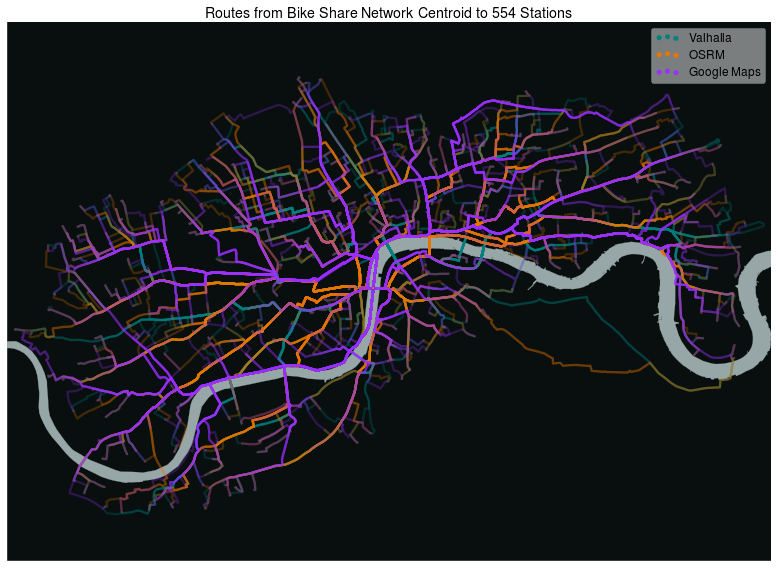

In [13]:
plt.clf()
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)


m.fillcontinents('#090F0F')
m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

pc_valhalla = PatchCollection([PolygonPatch(
    line.buffer(25)) for line in combined_routes['valhalla']],
    match_original=False, alpha=.25, color="#008080", lw=.01, zorder=4)
pc_valhalla.set_label("valhalla")

pc_osrm = PatchCollection([PolygonPatch(
    line.buffer(25)) for line in combined_routes['osrm']],
    match_original=False, alpha=.25, color="#E87600", lw=.01, zorder=4)
pc_osrm.set_label("osrm")


pc_gmaps = PatchCollection([PolygonPatch(
    line.buffer(25)) for line in combined_routes['gmaps']],
    match_original=False, alpha=.25, color="#9B30FF", lw=.01, zorder=4)
pc_gmaps.set_label("gmaps")

# ax.add_collection(pc_valhalla)
# ax.add_collection(pc_osrm)
# ax.add_collection(pc_gmaps)

# cascade Thames polygons together, and plot
thames = m.readshapefile(
    'thames_wgs84',
    'thames',
    color='none',
    zorder=4)
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#97a7a7', lw=.25, alpha=1., zorder=3)
ax.add_collection(tp)

# add centroid
centroid = m(-0.12204, 51.50083)
m.scatter(*centroid,
    s=5., edgecolor='#000000', alpha=1.,
    color='w', zorder=5)

# fake a legend. Tsk
lt = m.scatter([], [], color="#008080")
lo = m.scatter([], [], color="#E87600")
lg = m.scatter([], [], color="#9B30FF")

labels = ["Valhalla", "OSRM", "Google Maps"]
leg = plt.legend([lt, lo, lg], labels)
leg.get_frame().set_alpha(0.5)

plt.title("Routes from Bike Share Network Centroid to %s Stations" % len(routes))
plt.tight_layout()
plt.savefig('routes.png', dpi=300, bbox_inches='tight', alpha=True, transparent=True)

# convenience functions for adding and removing PatchCollections 
def remove_patches(ax, label):
    """ find and remove a PatchCollection by name """
    for idx, pc in enumerate(ax.collections):
        if pc.get_label() == label:
            ax.collections.pop(idx)

def display_valhalla(Valhalla):
    """ Display or remove Valhalla layer according to boolean input """
    if Valhalla:
        ax.add_collection(pc_valhalla)
    else:
        remove_patches(ax, "valhalla")
    display(fig)

def display_osrm(OSRM):
    """ Display or remove OSRM layer according to boolean input """
    if OSRM:
        ax.add_collection(pc_osrm)
    else:
        remove_patches(ax, "osrm")
    display(fig)
    
def display_gmaps(GMaps):
    """ Display or remove GMaps layer according to boolean input """
    if GMaps:
        ax.add_collection(pc_gmaps)
    else:
        remove_patches(ax, "gmaps")
    display(fig)

plt.close(fig)
interact(display_valhalla, Valhalla=True)
interact(display_osrm, OSRM=True)
interact(display_gmaps, GMaps=True)
plt.show()

## Outputting our decoded Polyline journeys to GeoJSON

Dumping to GeoJSON is straightforward.  

- import `geojson`
- encode each LineString as a Feature
- wrap the list of Features in a FeatureCollection
- dump the FeatureCollection as a JSON string

In [40]:
for provider in ['osrm', 'valhalla', 'gmaps']:
    with open('html/%s_geojson.json' % provider, 'w') as f:
        f.write(gj_dumps(FeatureCollection(
                    [Feature(geometry=feat) for feat in list(merged['%s_decoded' % provider])])))